In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Have a look on table columns of Measurement
# record = engine.execute("select * from Measurement")
# print(record.keys())

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Have a look on table columns of Station
# record = engine.execute("select * from Station")
# print(record.keys())

inspector = inspect(engine)
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


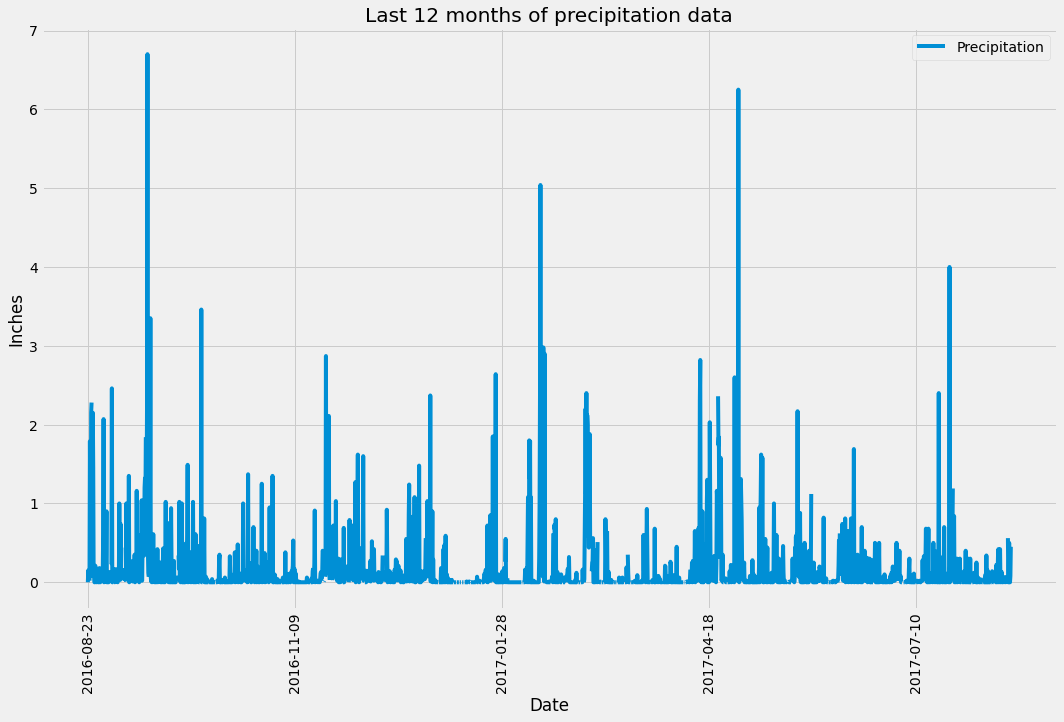

In [12]:
import datetime as dt
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_string = last_date[0]

# Calculate the date 1 year ago from the last data point in the database
lastDate_datetime = dt.date(int(last_date_string[0:4]), int(last_date_string[5:7]),int(last_date_string[8:10]) )
one_year_before_last_date = lastDate_datetime - dt.timedelta(days=365)
one_year_before_last_date

# Perform a query to retrieve the data and precipitation scores
one_year_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_before_last_date).\
    order_by(Measurement.date).all()
one_year_data

# Save the query results as a Pandas DataFrame and set the index to the date column
one_year_precipitation_df = pd.DataFrame(one_year_data, columns=["Date", "Precipitation"])
one_year_precipitation_df.set_index("Date")
# Sort the dataframe by date
one_year_precipitation_df.sort_index(ascending=True).set_index("Date")
# Use Pandas Plotting with Matplotlib to plot the data


one_year_precipitation_df.plot("Date","Precipitation",legend="precipitation")
#x_ticks = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10',]
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.title("Last 12 months of precipitation data")
plt.grid(which='minor', axis='x')
plt.legend(loc="upper right")

plt.show()



In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_year_precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations_available = session.query(Station.station).group_by(Station.station).count()
stations_available
print(f"There are {stations_available} stations available in this dataset.")

There are 9 stations available in this dataset.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations
for i in np.arange(9):
    print(f"Station {active_stations[i][0]} has the observation counts of {active_stations[i][1]}.")

most_active_station = active_stations[0][0]

print(f"\nThe most active station is {most_active_station}")

Station USC00519281 has the observation counts of 2772.
Station USC00519397 has the observation counts of 2724.
Station USC00513117 has the observation counts of 2709.
Station USC00519523 has the observation counts of 2669.
Station USC00516128 has the observation counts of 2612.
Station USC00514830 has the observation counts of 2202.
Station USC00511918 has the observation counts of 1979.
Station USC00517948 has the observation counts of 1372.
Station USC00518838 has the observation counts of 511.

The most active station is USC00519281


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_temps = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
station_temps

print(f"For the most active station {station_temps[0][0]}, the lowest temperature recorded was {station_temps[0][1]}, highest temperature recorded was {station_temps[0][2]}, average temperature was {round(station_temps[0][3],2)}.")

For the most active station USC00519281, the lowest temperature recorded was 54.0, highest temperature recorded was 85.0, average temperature was 71.66.


Text(0.5, 1.0, 'Last 12 months of temperature observation data (TOBS)')

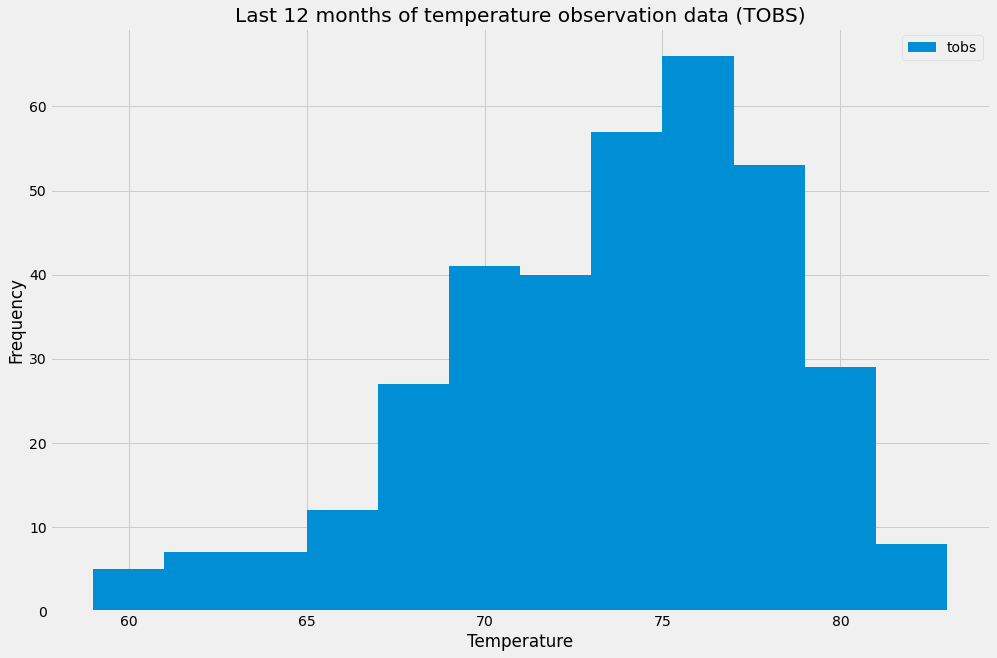

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station_temp_one_year = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_before_last_date).all()


most_active_station_temp_one_year_df = pd.DataFrame(most_active_station_temp_one_year, columns=["Date", "Temperature"])
most_active_station_temp_one_year_df.set_index("Date")

plt.hist(most_active_station_temp_one_year_df["Temperature"], bins=12, label="tobs")
plt.legend(loc="upper right")
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title("Last 12 months of temperature observation data (TOBS)")

## Bonus Challenge Assignment

### Temperature Analysis I

In [18]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
jun_str = "06"
jun_avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == jun_str).\
    group_by(Measurement.date).all()
jun_avg_temp

[(73.55555555555556,),
 (74.55555555555556,),
 (74.44444444444444,),
 (72.88888888888889,),
 (76.0,),
 (76.0,),
 (74.25,),
 (75.625,),
 (75.88888888888889,),
 (75.75,),
 (78.0,),
 (75.0,),
 (77.0,),
 (73.42857142857143,),
 (74.25,),
 (74.75,),
 (75.11111111111111,),
 (72.0,),
 (76.25,),
 (77.42857142857143,),
 (75.71428571428571,),
 (74.88888888888889,),
 (75.11111111111111,),
 (75.0,),
 (73.11111111111111,),
 (73.66666666666667,),
 (76.5,),
 (74.44444444444444,),
 (74.11111111111111,),
 (75.0,),
 (73.875,),
 (75.0,),
 (69.625,),
 (69.5,),
 (74.0,),
 (73.85714285714286,),
 (72.28571428571429,),
 (74.44444444444444,),
 (75.0,),
 (75.28571428571429,),
 (75.5,),
 (75.14285714285714,),
 (74.22222222222223,),
 (74.88888888888889,),
 (75.11111111111111,),
 (74.125,),
 (74.375,),
 (76.0,),
 (75.57142857142857,),
 (74.125,),
 (72.55555555555556,),
 (73.625,),
 (72.0,),
 (74.25,),
 (76.42857142857143,),
 (73.16666666666667,),
 (74.25,),
 (73.125,),
 (73.57142857142857,),
 (72.16666666666667,),


In [19]:
# Do the same for December temperature.
dec_str = "12"
dec_avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == dec_str).\
    group_by(Measurement.date).all()
dec_avg_temp

[(73.125,),
 (72.5,),
 (71.875,),
 (74.85714285714286,),
 (71.28571428571429,),
 (65.11111111111111,),
 (66.22222222222223,),
 (65.66666666666667,),
 (74.44444444444444,),
 (65.22222222222223,),
 (69.25,),
 (69.71428571428571,),
 (70.22222222222223,),
 (71.77777777777777,),
 (71.77777777777777,),
 (66.44444444444444,),
 (66.125,),
 (69.0,),
 (69.28571428571429,),
 (71.16666666666667,),
 (70.5,),
 (69.0,),
 (69.71428571428571,),
 (69.28571428571429,),
 (71.4,),
 (71.71428571428571,),
 (74.42857142857143,),
 (70.71428571428571,),
 (72.71428571428571,),
 (72.28571428571429,),
 (74.0,),
 (68.75,),
 (69.125,),
 (72.42857142857143,),
 (72.28571428571429,),
 (71.375,),
 (71.125,),
 (69.75,),
 (70.75,),
 (69.14285714285714,),
 (72.14285714285714,),
 (71.66666666666667,),
 (73.125,),
 (70.25,),
 (69.875,),
 (71.375,),
 (70.0,),
 (70.66666666666667,),
 (71.42857142857143,),
 (72.14285714285714,),
 (71.57142857142857,),
 (70.0,),
 (71.14285714285714,),
 (71.0,),
 (69.57142857142857,),
 (72.833333

In [20]:
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats

In [21]:
stats.ttest_ind(jun_avg_temp, dec_avg_temp, equal_var=False)

Ttest_indResult(statistic=array([19.02480907]), pvalue=array([1.25228894e-57]))

#### As the p-value is 1.25228894e-57, which is very small, this indicated that the average temperature in June and December is significantly different.

### Temperature Analysis II

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_date = "2018-01-01"
previous_trip_date = "2017-01-01"
previous_data = calc_temps(previous_trip_date, trip_date)
# Use the average temperature as the bar height.
bar_height = previous_data[0][1]
# Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).
y_error_bar = previous_data[0][2] - previous_data[0][0]
previous_data

[(58.0, 74.14387974230493, 87.0)]

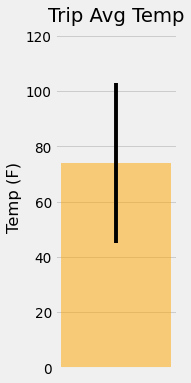

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2, 6), dpi=70)
plt.bar(x=[0] ,height=bar_height, yerr=y_error_bar, color="orange", alpha=0.5)
plt.grid(which='major', axis='x')
plt.gca().axes.get_xaxis().set_visible(False)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.ylim(0, bar_height+y_error_bar+20)
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, Station.latitude, Station.longitude, 
       Station.elevation, func.sum(Measurement.prcp)]
prcp_record = session.query(*sel).filter(Station.station==Measurement.station).\
    filter(Measurement.date>=previous_trip_date).filter(Measurement.date<=trip_date).\
    group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
prcp_record_df = pd.DataFrame(prcp_record, columns=["station", "Name", "Latitude", "Longitude", "Elevation", "Total Precipitation"])
prcp_record_df

,station,Name,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,68.78
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,43.66
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,34.62
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,27.32
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,21.80
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,10.66
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,3.39


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normal = []
# Set the start and end date of the trip
trip_start = "2017-10-09"
trip_end = "2017-10-15"
# Use the start and end date to create a range of dates
trip_start_to_date = dt.datetime.strptime(trip_start, "%Y-%m-%d")
trip_end_to_date = dt.datetime.strptime(trip_end, "%Y-%m-%d")
# Loop through the list of %m-%d strings and calculate the normals for each date
trip_day = trip_start_to_date
trip_date_list = []
while trip_day<=trip_end_to_date:    
    # Stip off the year and save a list of %m-%d strings
    trip_date_to_str = dt.datetime.strftime(trip_day, "%m-%d")    
    trip_date_list.append(dt.datetime.strftime(trip_day, "%Y-%m-%d"))
    normal.append(np.ravel(daily_normals(trip_date_to_str)))
    trip_day += dt.timedelta(days=1)


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normal, columns=["Min Temp", "Avg Temp", "Max Temp"])
normal_df["Date"] = trip_date_list
normal_df = normal_df.set_index("Date")
normal_df

,Min Temp,Avg Temp,Max Temp
Date,,,
2017-10-09,69.0,76.113636,84.0
2017-10-10,69.0,75.854167,83.0
2017-10-11,69.0,76.571429,84.0
2017-10-12,65.0,75.755102,82.0
2017-10-13,65.0,75.980392,84.0
2017-10-14,67.0,75.192308,82.0
2017-10-15,67.0,75.634615,82.0


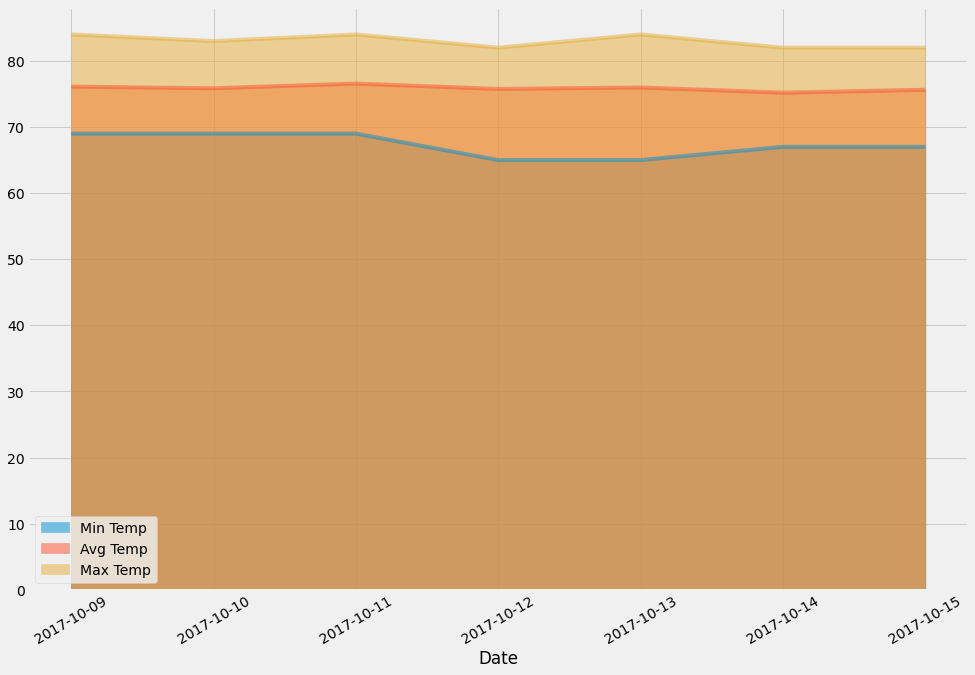

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot.area(stacked=False)
plt.xticks(rotation=30)
plt.show()